In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

from astropy.table import Table
import astropy.units as u

In [2]:
import arya
import surp
from surp.gce_math import is_high_alpha
from surp._globals import DATA_DIR

/users/PAS2232/aeyobd/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


Apogee can be downloaded from https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStar-dr17-synspec_rev1.fits, and astroNN from https://data.sdss.org/sas/dr17/env/APOGEE_ASTRO_NN/apogee_astroNN-DR17.fits.

In [3]:
filename = surp._globals.DATA_DIR + "allStar-dr17-synspec_rev1.fits.1"
da = Table.read(filename, format="fits", hdu=1)

'ancillary young embedded cluster member', 'ancillary emission line star', 'MIR-detected candidate cluster member (ancillary)', 

APOGEE2_Target3: 'Selected as part of the EB program', 'Selected as part of the young cluster study (IN-SYNC)', 'Ancillary W3/4/5 star forming complex'

              

Finally, I restrict to the given Log(g)-Teff domain:
log(g) ≥ 3.5
log(g) ≤ 0.004 ∗ (𝑇eff ) − 15.7
log(g) ≤ 0.00070588 ∗ (𝑇eff ) + 0.358836
log(g) ≤ −0.0015 ∗ (𝑇eff ) + 12.05
log(g) ≥ 0.0012 ∗ (𝑇eff ) − 2.8

In [4]:
apogee_target2 = 1<<17 #APOGEE_MIRCLUSTER_STAR
apogee_target2 ^= 1<<15 #APOGEE_EMISSION_STAR  emission line stars
apogee_target2 ^= 1<<13 #APOGEE_EMBEDDEDCLUSTER_STAR embedded cluster

In [5]:
apogee2_target3 = 1<<5 # young cluster (IN-SYNC)
apogee2_target3 ^= 1<<18 #APOGEE2_W345
apogee2_target3 ^= 1<<1 # EB planet

In [11]:
apogee_aspcapflag = 1<<23 # starbad
apogee_aspcapflag ^= 1<<31 # no_aspcap_result

In [35]:
mask = (da["APOGEE2_TARGET3"] & apogee2_target3) == 0
print(sum(mask))
mask &= (da["APOGEE_TARGET2"] & apogee_target2) == 0
print(sum(mask))

mask &= (da["ASPCAPFLAG"] & apogee_aspcapflag) == 0
print(sum(mask))

721431
717682
680297


In [36]:
logg = da["LOGG"]
teff = da["TEFF"]

mask &= logg >= 3.5
mask &= logg <= 0.004*teff - 15.7
mask &= logg <= 0.000706*teff + 0.36
mask &= logg <= -0.0015 * teff + 12.05
mask &= logg >= 0.0012*teff - 2.8
print(sum(mask))

16412


In [37]:
mask &= ~da["FE_H"].mask
print(sum(mask))

mask &= ~da["MG_FE"].mask 
print(sum(mask))

mask &= ~da["C_FE"].mask
print(sum(mask))

16406
41


Jack's coordinates are

- (3.5, 4800)
- (3.8, 4875)
- (4.1, 5300)
- (3.8, 5500)
- (3.5, 5250)


In [9]:
coords = [
    (3.5, 4800),
    (3.8, 4875),
    (4.1, 5300),
    (3.8, 5500),
    (3.5, 5250),
    (3.5, 4800)
]
y = [c[0] for c in coords]
x = [c[1] for c in coords]

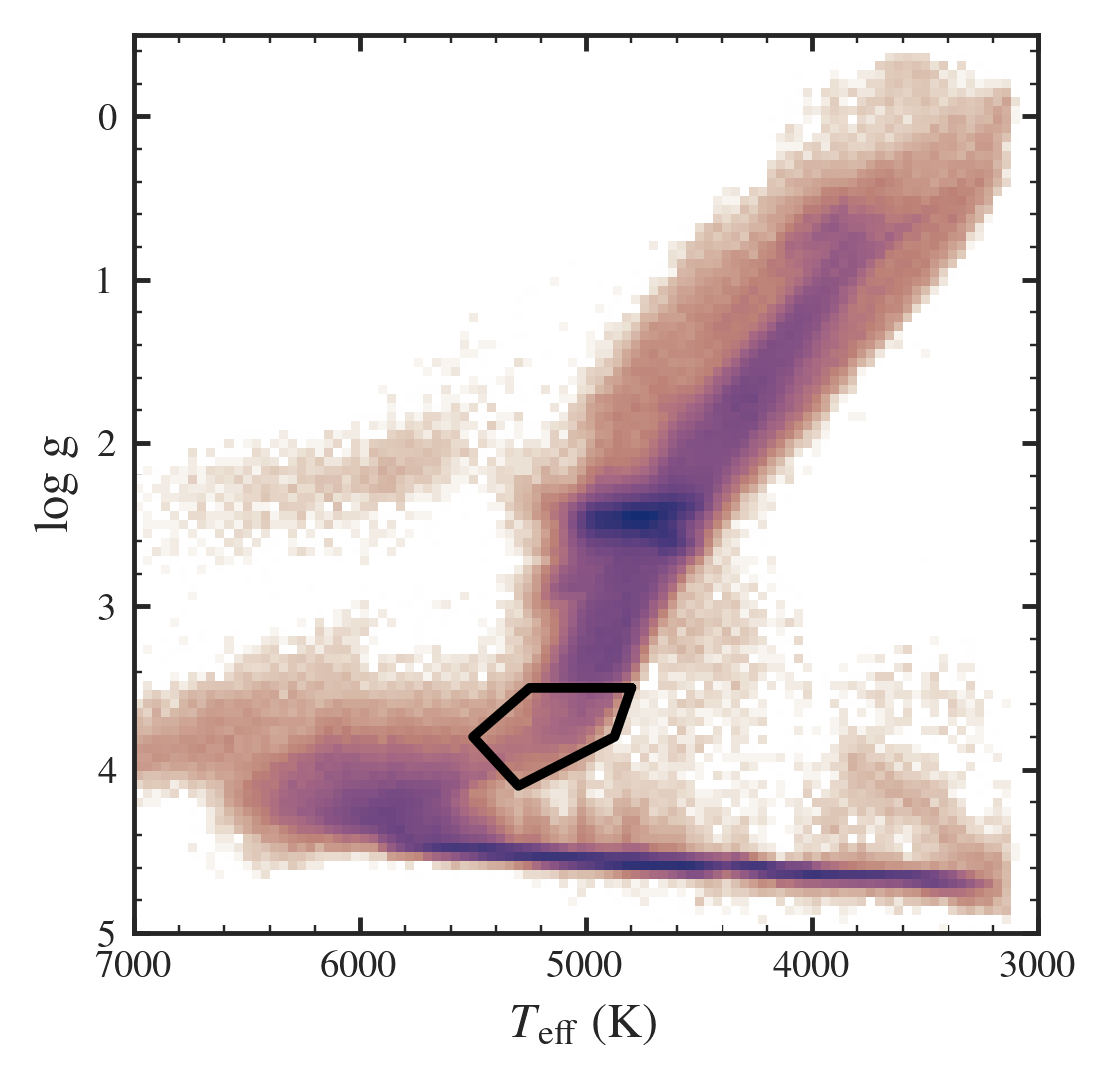

In [10]:
plt.figure(figsize=(10/3, 10/3), rasterized=True, dpi=350)
_, _, _, img = plt.hist2d(da["TEFF"], da["LOGG"], range=((3000, 7000), (-0.5, 5)), bins=100, norm="log", cmin=3, cmap=arya.style.get_cmap(to_white=True, reverse=True))
img.set_edgecolor("none")


plt.plot(x, y, lw=2, color="k")

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.xlabel("$T_{\\rm eff}$ (K)")
plt.ylabel("$\\log$ g")
plt.savefig("logg_jack.pdf")

In [12]:
# cuts in W+19
filtered = da[mask]
names = [name for name in filtered.colnames if len(filtered[name].shape) <= 1]
filtered = filtered[names].to_pandas()

del da

In [13]:
astroNN = Table.read(surp._globals.DATA_DIR + "apogee_astroNN-DR17.fits", format="fits", hdu=1)

names = [name for name in astroNN.colnames if len(astroNN[name].shape) <= 1]
astroNN = astroNN[names].to_pandas()

In [14]:
astroNN = astroNN[~astroNN["APOGEE_ID"].duplicated(keep="first")].copy()

In [15]:
def bracket(df, ele, ele2="H"):
    """
    Helper function for subgiants()
    creates the abundance ratio [A/B]
    from the  APOGEE dataframe
    """
    if ele2 == "H":
        if ele == "FE":
            return df["FE_H"]
        else:
            return df["%s_FE" % ele] + df["FE_H"]
    else:
        if ele2 == "FE":
            return df["%s_FE" % ele]
        else:
            return df["%s_FE" % ele] - df["%s_FE" % ele2]


In [16]:
df_a = filtered
astroNN.set_index("APOGEE_ID", inplace=True)
df = df_a.set_index("APOGEE_ID").join(astroNN, rsuffix="_ANN").copy()

In [17]:
df["R_gal"] = df.galr
df["z_gal"] = df.galz

df["abs_z"] = np.abs(df.z_gal)

# Add useful abundance ratios
df["O_H"] = bracket(df, "O")
df["MG_H"] = bracket(df, "MG")
df["C_O"] = bracket(df, "C", "O")
df["C_MG"] = bracket(df, "C", "MG")
df["C_H"] = bracket(df, "C", "H")

df["C_N"] = bracket(df, "C", "N")
df["N_H"] = bracket(df, "N", "H")
df["N_O"] = bracket(df, "N", "O")
df["N_MG"] = bracket(df, "N", "MG")

df["FE_O"] = -df["O_FE"]
df["FE_MG"] = -df["MG_FE"]

df["C_MG_ERR"] = df["C_FE_ERR"] + df["MG_FE_ERR"]
df["N_MG_ERR"] = df["N_FE_ERR"] + df["MG_FE_ERR"]
df["C_N_ERR"] = df["N_FE_ERR"] + df["C_FE_ERR"]

# add high/low alpha column
df["high_alpha"] = is_high_alpha(df["MG_FE"], df.FE_H)


In [18]:
df.to_csv(DATA_DIR + "subgiants.csv")

In [19]:
del astroNN

<Axes: xlabel='R_gal', ylabel='Density'>

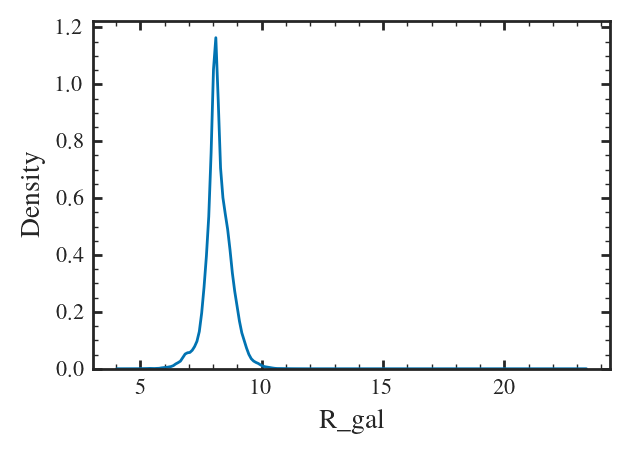

In [20]:
sns.kdeplot(df.R_gal)

In [21]:
pd.read_csv("../../data/subgiants.csv")

/tmp/slurmtmp.26910129/ipykernel_120063/1590072509.py:1: DtypeWarning: Columns (109) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv("../../data/subgiants.csv")


,APOGEE_ID,FILE,TARGET_ID,APSTAR_ID,ASPCAP_ID,TELESCOPE,LOCATION_ID,FIELD,ALT_ID,RA,...,C_MG,C_N,N_O,N_MG,FE_O,FE_MG,C_MG_ERR,N_MG_ERR,C_N_ERR,high_alpha
0,b'2M00002185+1459100',b'apStar-dr17-2M00002185+1459100.fits',b'apo25m.107-46_MGA.2M00002185+1459100',b'apogee.apo25m.stars.107-46_MGA.2M00002185+14...,b'apogee.apo25m.synspec_fix.107-46_MGA.2M00002...,b'apo25m',2897,b'107-46_MGA',b'none',0.091079,...,-0.181092,0.091994,-0.138211,-0.273086,-0.017901,-0.152776,0.056999,0.059576,0.072282,False
1,b'2M00004159+6505249',b'apStar-dr17-2M00004159+6505249.fits',b'apo25m.117+01.2M00004159+6505249',b'apogee.apo25m.stars.117+01.2M00004159+6505249',b'apogee.apo25m.synspec_fix.117+01.2M00004159+...,b'apo25m',4591,b'117+01',b'none',0.173321,...,-0.128050,-0.218545,0.165167,0.090495,-0.016283,-0.090955,0.023487,0.026611,0.027649,False
2,b'2M00004251+5643075',b'apStar-dr17-2M00004251+5643075.fits',b'apo25m.NGC7789_btx.2M00004251+5643075',b'apogee.apo25m.stars.NGC7789_btx.2M00004251+5...,b'apogee.apo25m.synspec_fix.NGC7789_btx.2M0000...,b'apo25m',5922,b'NGC7789_btx',b'none',0.177160,...,0.030329,-0.221919,0.227355,0.252248,-0.032445,-0.007552,0.027562,0.031243,0.034933,False
3,b'2M00005728+6958488',b'apStar-dr17-2M00005728+6958488.fits',b'apo25m.120+08.2M00005728+6958488',b'apogee.apo25m.stars.120+08.2M00005728+6958488',b'apogee.apo25m.synspec_fix.120+08.2M00005728+...,b'apo25m',4120,b'120+08',b'none',0.238695,...,-0.087583,0.299130,-0.224807,-0.386713,-0.078000,-0.239906,0.040150,0.043540,0.049279,True
4,b'2M00012854+7021553',b'apStar-dr17-2M00012854+7021553.fits',b'apo25m.120+08.2M00012854+7021553',b'apogee.apo25m.stars.120+08.2M00012854+7021553',b'apogee.apo25m.synspec_fix.120+08.2M00012854+...,b'apo25m',4120,b'120+08',b'none',0.368950,...,-0.138952,-0.395929,0.176989,0.256977,-0.129130,-0.049142,0.039708,0.043409,0.050715,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16360,b'AP17330103-3840133',b'asStar-dr17-AP17330103-3840133.fits',b'lco25m.350-03-C.AP17330103-3840133',b'apogee.lco25m.stars.350-03-C.AP17330103-3840...,b'apogee.lco25m.synspec_fix.350-03-C.AP1733010...,b'lco25m',6017,b'350-03-C',b'JVVVPM220',263.254290,...,-0.098114,0.095691,-0.212428,-0.193805,-0.122089,-0.103466,0.052757,0.055783,0.069352,False
16361,b'AP17345997-3904553',b'asStar-dr17-AP17345997-3904553.fits',b'lco25m.350-03-C.AP17345997-3904553',b'apogee.lco25m.stars.350-03-C.AP17345997-3904...,b'apogee.lco25m.synspec_fix.350-03-C.AP1734599...,b'lco25m',6017,b'350-03-C',b'JVVVPM223',263.749860,...,-0.067194,-0.085825,0.052848,0.018631,-0.038246,-0.072463,0.033984,0.037630,0.042081,False
16362,b'AP17361724-3847320',b'asStar-dr17-AP17361724-3847320.fits',b'lco25m.350-03-C.AP17361724-3847320',b'apogee.lco25m.stars.350-03-C.AP17361724-3847...,b'apogee.lco25m.synspec_fix.350-03-C.AP1736172...,b'lco25m',6017,b'350-03-C',b'JVVVPM281',264.071850,...,-0.094817,0.055768,-0.117759,-0.150585,-0.072073,-0.104899,0.042347,0.048883,0.059468,False
16363,b'AP17375311-3925316',b'asStar-dr17-AP17375311-3925316.fits',b'lco25m.350-03-C.AP17375311-3925316',b'apogee.lco25m.stars.350-03-C.AP17375311-3925...,b'apogee.lco25m.synspec_fix.350-03-C.AP1737531...,b'lco25m',6017,b'350-03-C',b'JVVVPM112',264.471280,...,-0.196011,-0.141531,-0.129975,-0.054480,-0.222173,-0.146678,0.053924,0.056932,0.068682,True


In [4]:
df = surp.subgiants

(5.0, 11.0)

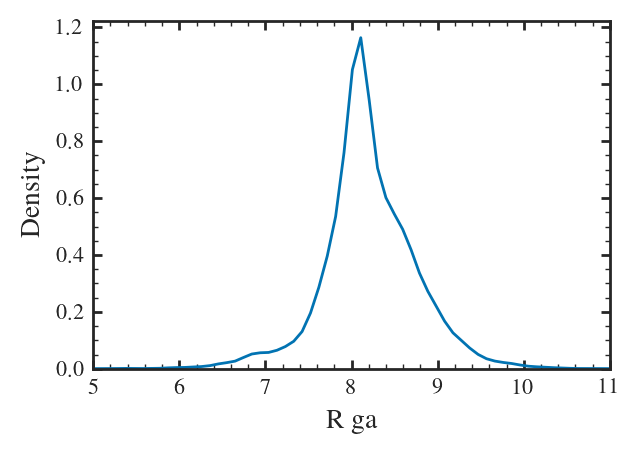

In [6]:
sns.kdeplot(df.R_gal)
plt.xlabel("R ga")
plt.xlim(5, 11)